<h1>Machine Learning</h1>

In [66]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR

%matplotlib inline

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data?datasetId=268833&sortBy=voteCount
df1 = pd.read_csv('AB_NYC_2019.csv', index_col='id')
df2 = pd.read_csv('listings.csv', index_col='id')

# juntando as duas bases em uma única:
colunas_relevantes = ["property_type", "accommodates",  "review_scores_value", 
                      "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", 
                      "review_scores_communication", "review_scores_checkin", "review_scores_rating", 
                      "maximum_nights", "host_is_superhost", "host_response_time", "host_response_rate",  
                      'bathrooms', 'bedrooms', 'beds']
nyc = pd.merge(df1, df2[colunas_relevantes], on='id', how='left')

C:\Users\James\AppData\Local\Temp\ipykernel_20044\3668734813.py:3: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('listings.csv', index_col='id')


# Análise Exploratória

In [4]:
type(nyc)

pandas.core.frame.DataFrame

In [5]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month         

In [6]:
nyc.isnull().sum()

name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
property_type                      3371
accommodates                       3371
review_scores_value               12629
review_scores_cleanliness         12594
review_scores_location            12631
review_scores_accuracy            12611
review_scores_communication       12605
review_scores_checkin             12627
review_scores_rating              12573
maximum_nights                     3371


Vamos dropar a coluna `last_review`, pois não é tão relevante para o modelo.

Como `review_scores` não tem um desvio padrão tão alto, vamos substituir os vazios pela média.

Para o restante, preencheremos com o valor da média.

In [7]:
nyc.drop(columns=['last_review'], inplace=True)

reviews = ['review_scores_value', 'review_scores_cleanliness', 
           'review_scores_location', 'review_scores_accuracy', 
           'review_scores_communication', 'review_scores_checkin', 
           'review_scores_rating']

for i in reviews:
    nyc[i].fillna(nyc[i].mean(), inplace=True)

nyc['accommodates'].fillna(nyc['accommodates'].mean(), inplace=True)
nyc['maximum_nights'].fillna(nyc['maximum_nights'].mean(), inplace=True)
nyc['reviews_per_month'] = nyc['number_of_reviews'] / 12

a = ['bathrooms', 'beds', 'bedrooms']
for i in a:
    nyc[i].fillna(nyc[i].mean(), inplace=True)

In [8]:
nyc.isnull().sum()

name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
property_type                      3371
accommodates                          0
review_scores_value                   0
review_scores_cleanliness             0
review_scores_location                0
review_scores_accuracy                0
review_scores_communication           0
review_scores_checkin                 0
review_scores_rating                  0
maximum_nights                        0
host_is_superhost                  3389


In [9]:
colunas_categoricas = ['host_response_time', 'host_response_rate', 'property_type', 'host_is_superhost']

for i in colunas_categoricas:
    nyc[i].fillna(nyc[i].value_counts().idxmax(), inplace=True)

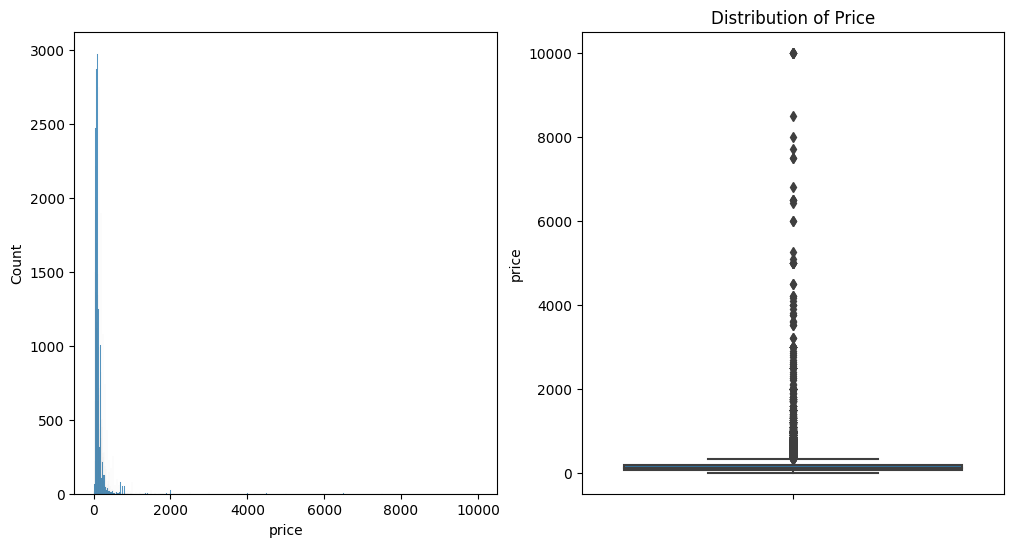

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(nyc['price'])

plt.subplot(1,2,2)
sns.boxplot(y=nyc['price'])
plt.title("Distribution of Price")
plt.show()

In [11]:
mean = nyc['price'].mean()
std = nyc['price'].std()

print(f"média: {mean}, desvio padrão: {std}")

média: 152.7206871868289, desvio padrão: 240.15416974718758


In [12]:
# Vamos remover valores acima de 3 desvios padrão

limite_max = mean + 3 * std
nyc = nyc[nyc['price'] <= limite_max]

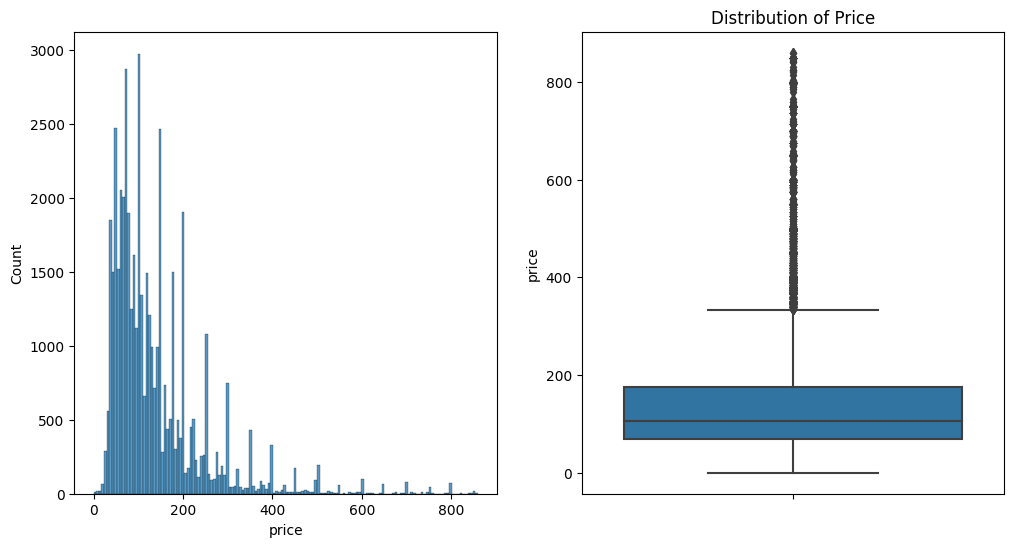

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(nyc['price'])

plt.subplot(1,2,2)
sns.boxplot(y=nyc['price'])
plt.title("Distribution of Price")
plt.show()

C:\Users\James\AppData\Local\Temp\ipykernel_20044\1696024740.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = nyc.corr()
C:\Users\James\AppData\Local\Temp\ipykernel_20044\1696024740.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot:>

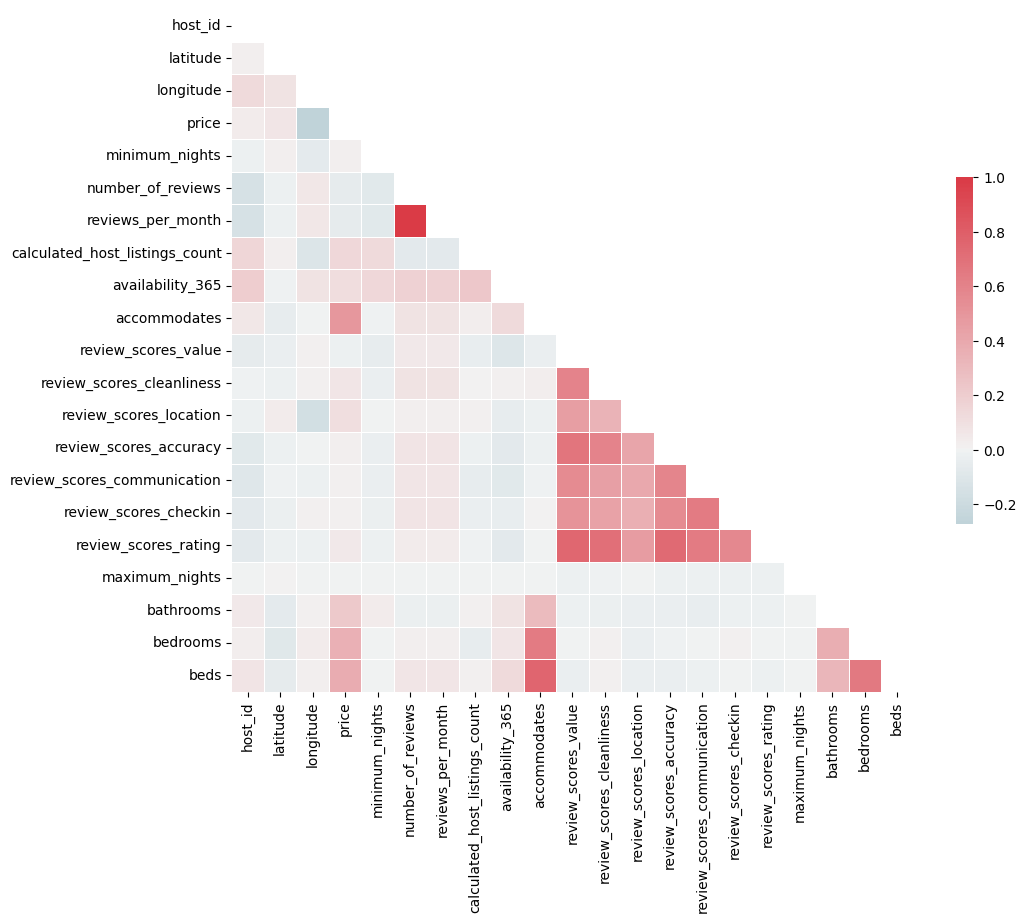

In [14]:
corr = nyc.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Percebe-se que os fatores de maior correlação são os `reviews` entre si. Porém, não estão relacionados com a variável de interesse `price`

Nota-se, porém, que a capacidade de acomodar, a quantidade de quartos, banheiros e camas pare ter forte correlação com o preço.

Além disso, é interessante notar que há uma correlação negativa entre longitude e preço. Ou seja, lugares mais ao sul de Nova Iorque tendem a ser mais caros.

Graficamente, podemos observar:

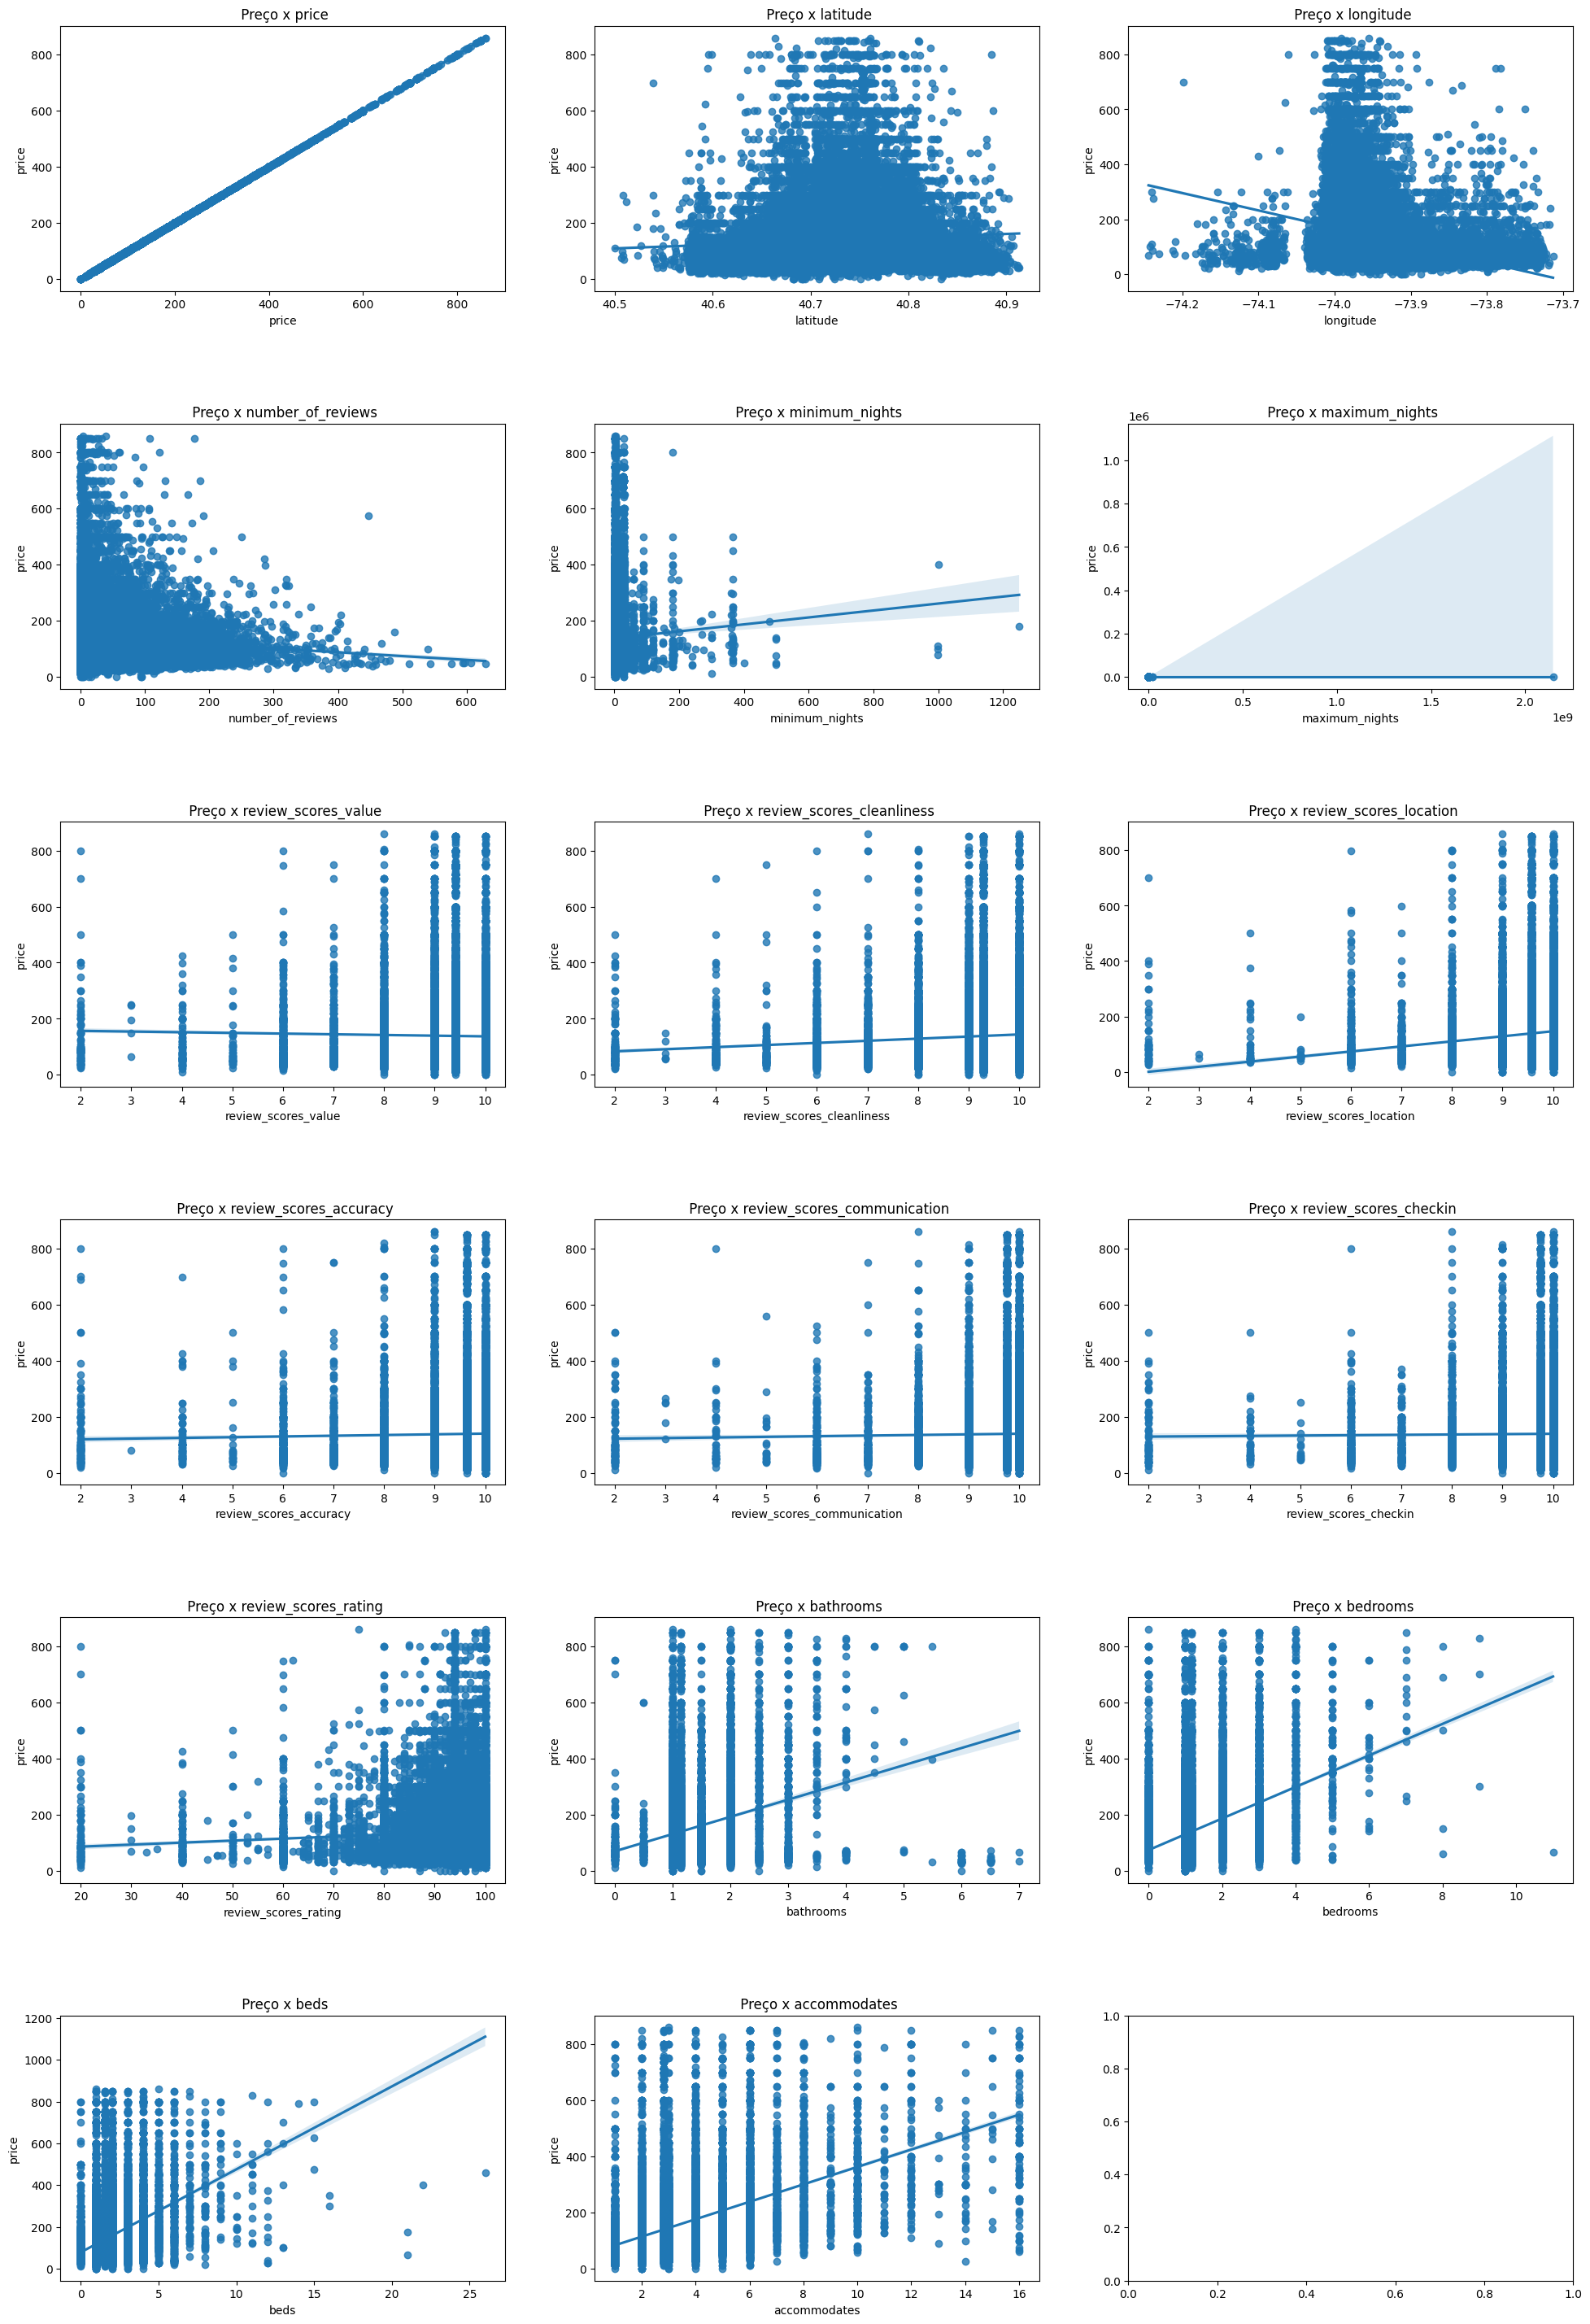

In [15]:
colunas_relevantes = ['price', 'latitude', 'longitude', 'number_of_reviews', 'minimum_nights', 'maximum_nights', 
                     'review_scores_value', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_accuracy', 
                     'review_scores_communication', 'review_scores_checkin', 'review_scores_rating',
                     'bathrooms', 'bedrooms', 'beds', 'accommodates', ]

newdf = nyc.loc[:, colunas_relevantes]
nrows = int(len(newdf.columns) / 3) + 1
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(24, 6*nrows))
fig.subplots_adjust(hspace=0.5)

for ax, name in zip(axes.flatten(), newdf.columns):
  
    sns.regplot(x=name, y='price', data=newdf, ax=ax)
    ax.set_title(f" Preço x {name}")

plt.show()

Para as variáveis categóricas, podemos ver como o preço se comporta diante de alguns agrupamentos. Para efeito de análise, vamos agrupar `neighbourhood_group` e `room_type` 

[]

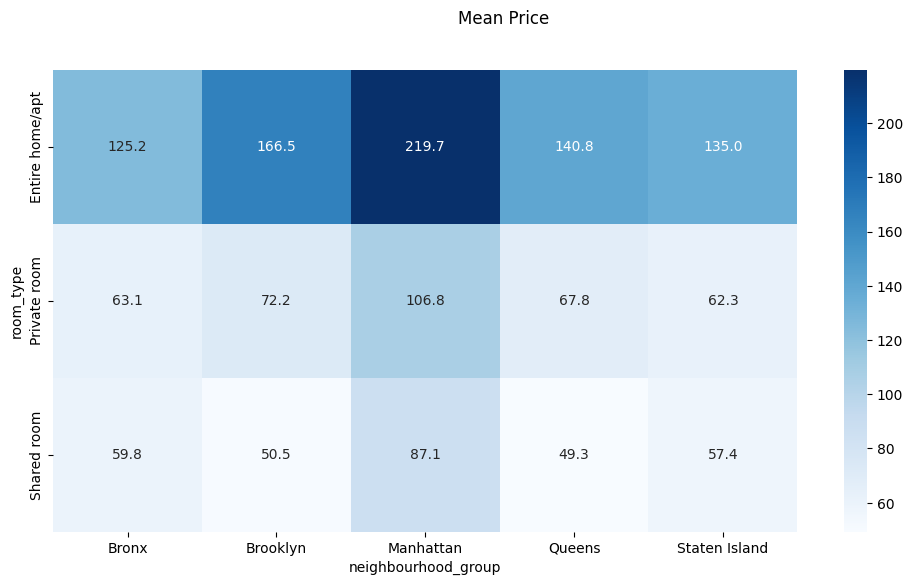

In [16]:
plt.figure(figsize=(12, 6))
df_pivot = nyc.pivot_table(values='price', index='room_type', columns='neighbourhood_group', aggfunc='mean')
sns.heatmap(df_pivot, annot=True, fmt='.1f', cmap='Blues')

plt.suptitle('Mean Price')
plt.plot()

Como era de se esperar, no geral, uma residência inteira é mais cara que um quarto privado, que é mais caro que um quarto compartilhado.

Agora que já temos uma noção minimamente melhor sobre nossa base de dados, podemos iniciar o estudo sobre os modelos de Machine Learning.


In [17]:
# filtrando apenas as linhas que possuem preço
nyc = nyc[nyc.price > 0]

# removendo colunas que não são relevantes para análise do preço
nyc.drop(columns=['name', 'host_id', 'host_name', 'reviews_per_month', 'host_response_rate'], inplace=True)

C:\Users\James\AppData\Local\Temp\ipykernel_20044\3271678948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc.drop(columns=['name', 'host_id', 'host_name', 'reviews_per_month', 'host_response_rate'], inplace=True)


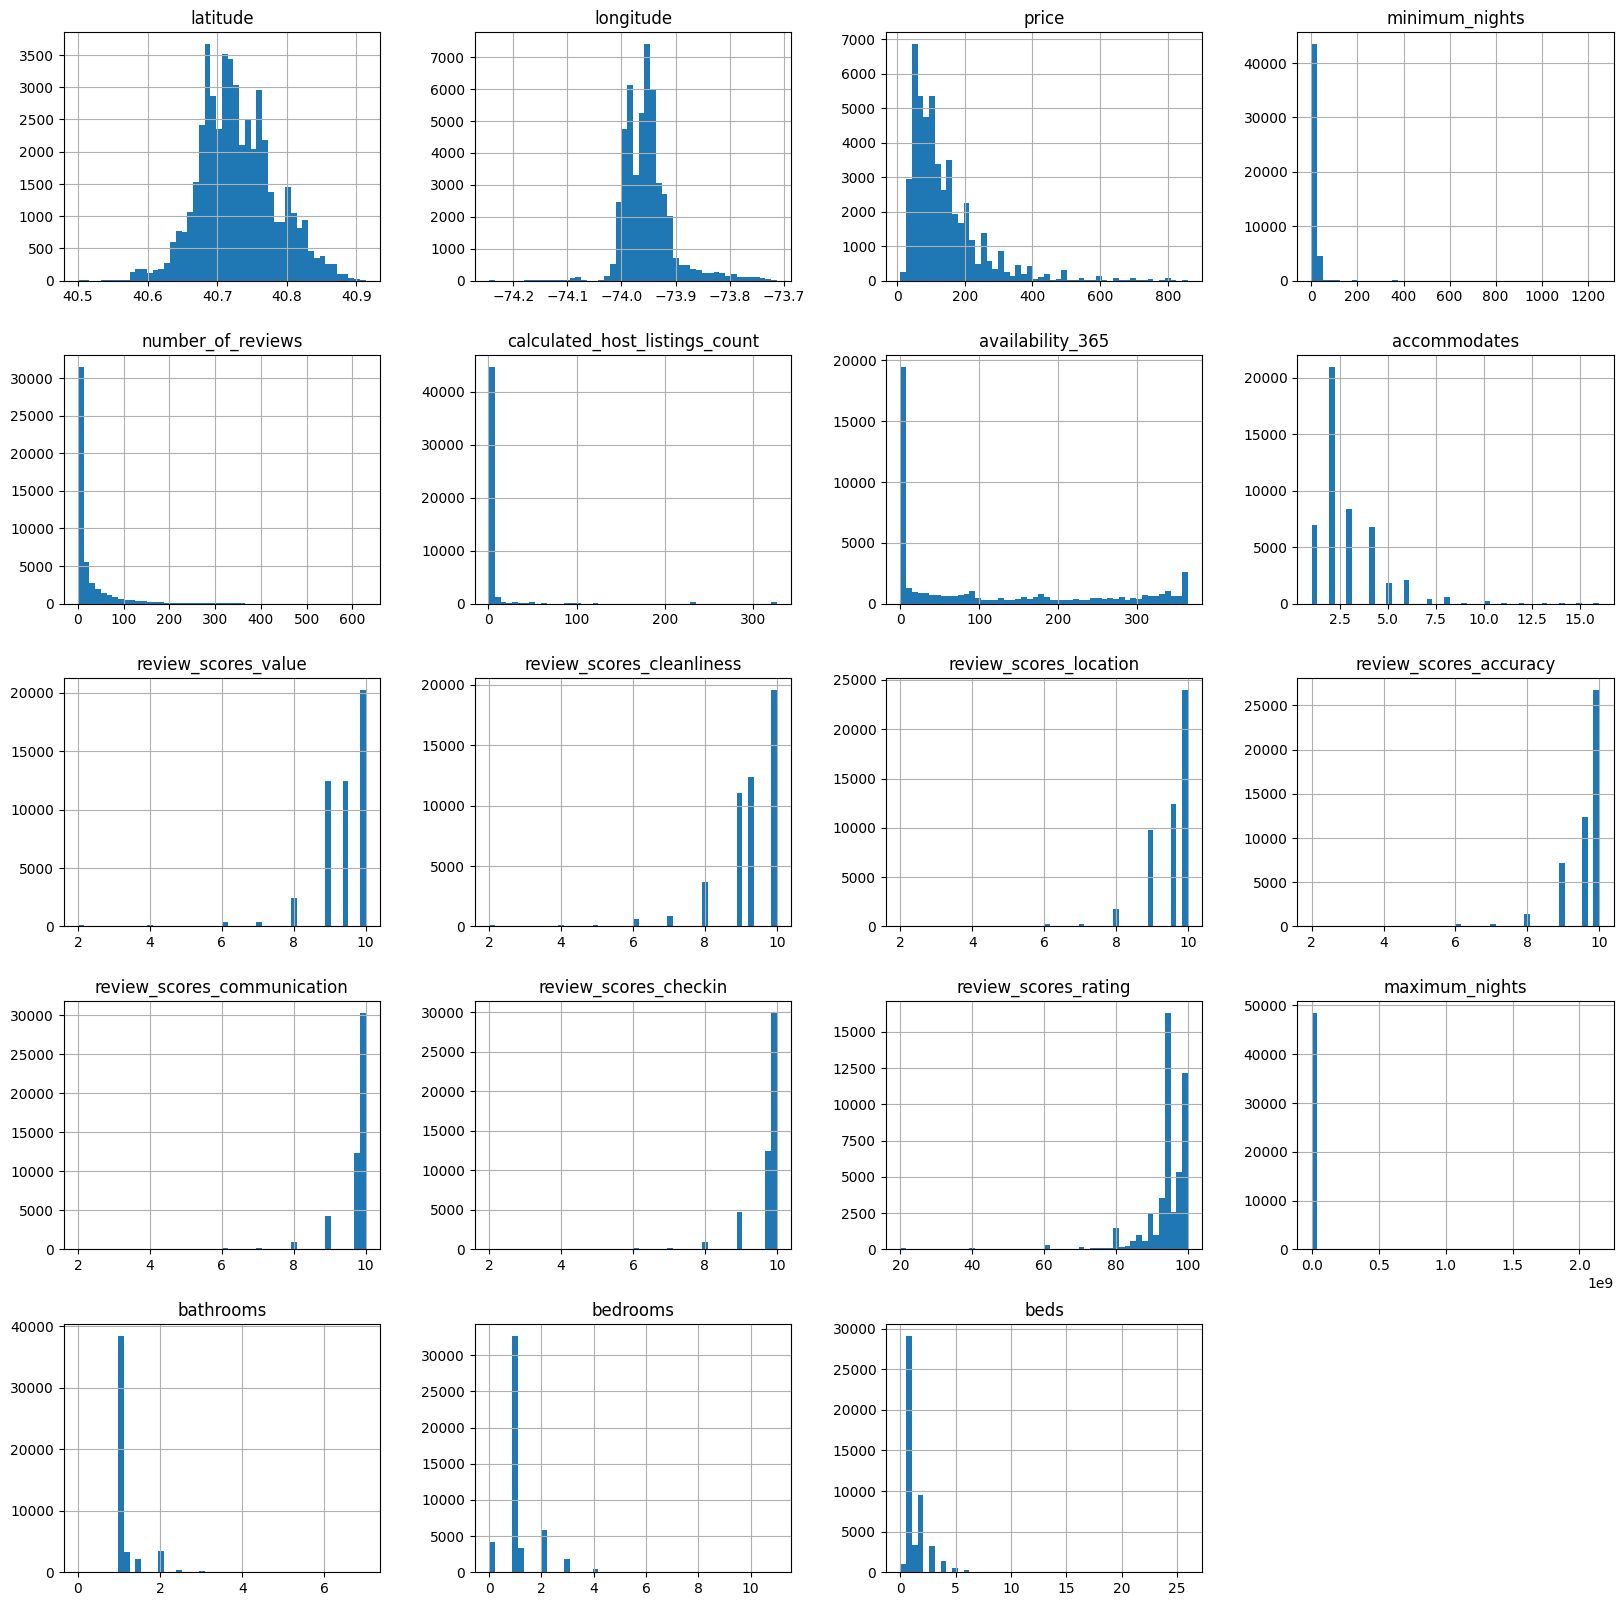

In [18]:
nyc.hist(bins=50, figsize=(20, 20))
plt.show()

In [19]:
# Verificando colunas categóricas
nyc["neighbourhood"].value_counts()

Williamsburg          3905
Bedford-Stuyvesant    3696
Harlem                2649
Bushwick              2459
Hell's Kitchen        1943
                      ... 
Fort Wadsworth           1
Richmondtown             1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: neighbourhood, Length: 221, dtype: int64

In [20]:
nyc["neighbourhood_group"].value_counts()

Manhattan        21377
Brooklyn         20011
Queens            5650
Bronx             1088
Staten Island      370
Name: neighbourhood_group, dtype: int64

In [21]:
nyc["room_type"].value_counts()

Entire home/apt    25100
Private room       22242
Shared room         1154
Name: room_type, dtype: int64

In [22]:
nyc["host_response_time"].value_counts()

within an hour        36617
within a few hours     6655
within a day           4400
a few days or more      824
Name: host_response_time, dtype: int64

In [23]:
nyc["host_is_superhost"].value_counts()

f    39264
t     9232
Name: host_is_superhost, dtype: int64

Visualizando por Neighbourhood Group

In [24]:
nyc['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

Text(0.5, 0, '')

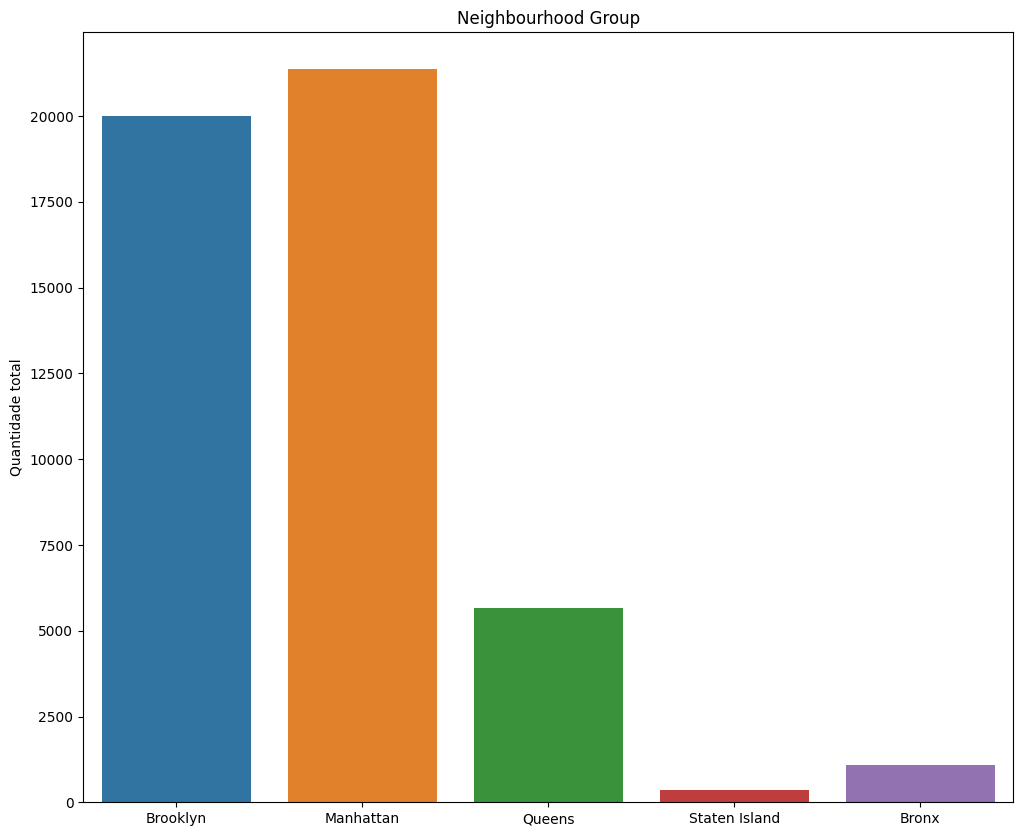

In [25]:
sns.countplot(data=nyc, x="neighbourhood_group")
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.title("Neighbourhood Group")
plt.ylabel("Quantidade total")
plt.xlabel("")


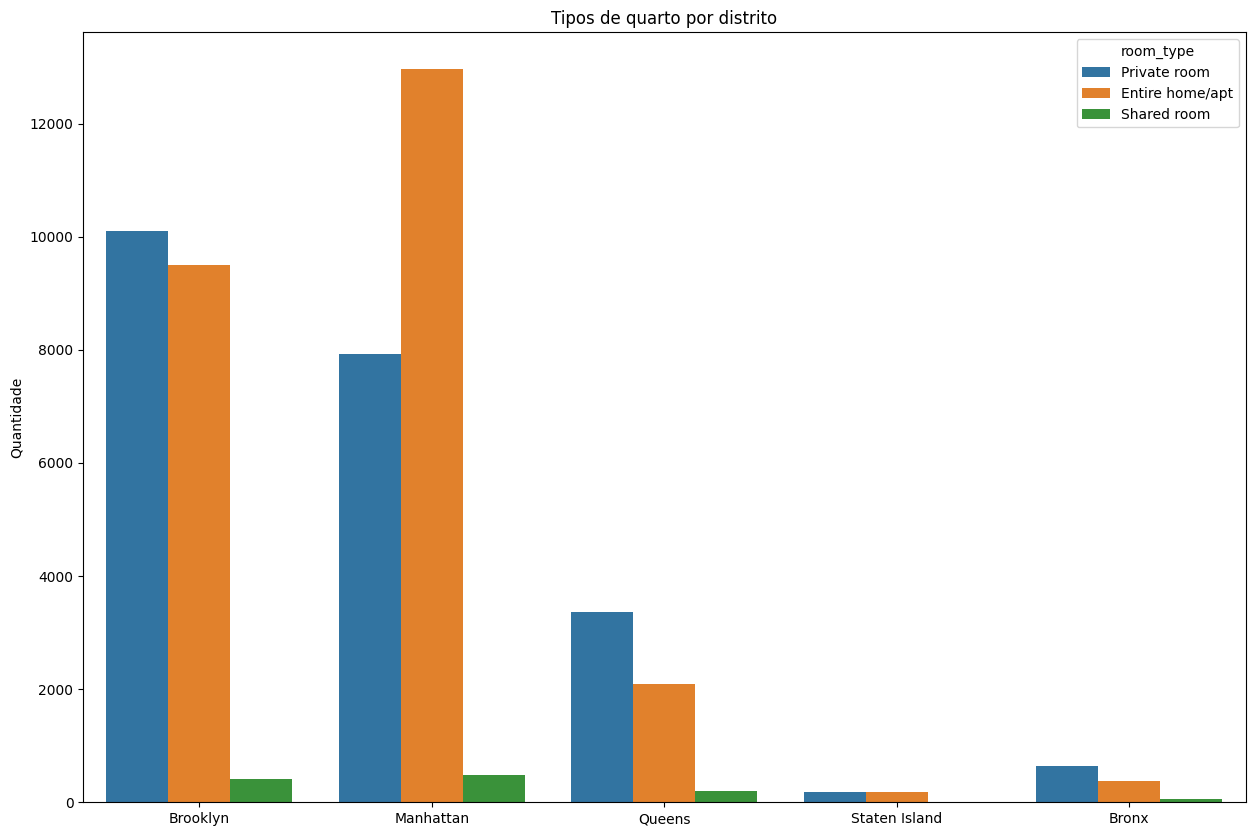

In [26]:
sns.countplot(
    data=nyc, 
    x="neighbourhood_group", 
    hue="room_type"
)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title("Tipos de quarto por distrito")
plt.xlabel("")
plt.ylabel("Quantidade")
plt.show()

In [27]:
# Explorando o top 10 dos bairros que mais aparecem
top10_neighbours = list(nyc["neighbourhood"].value_counts().head(10).index)
top10_neighbours

['Williamsburg',
 'Bedford-Stuyvesant',
 'Harlem',
 'Bushwick',
 "Hell's Kitchen",
 'Upper West Side',
 'East Village',
 'Upper East Side',
 'Crown Heights',
 'Midtown']

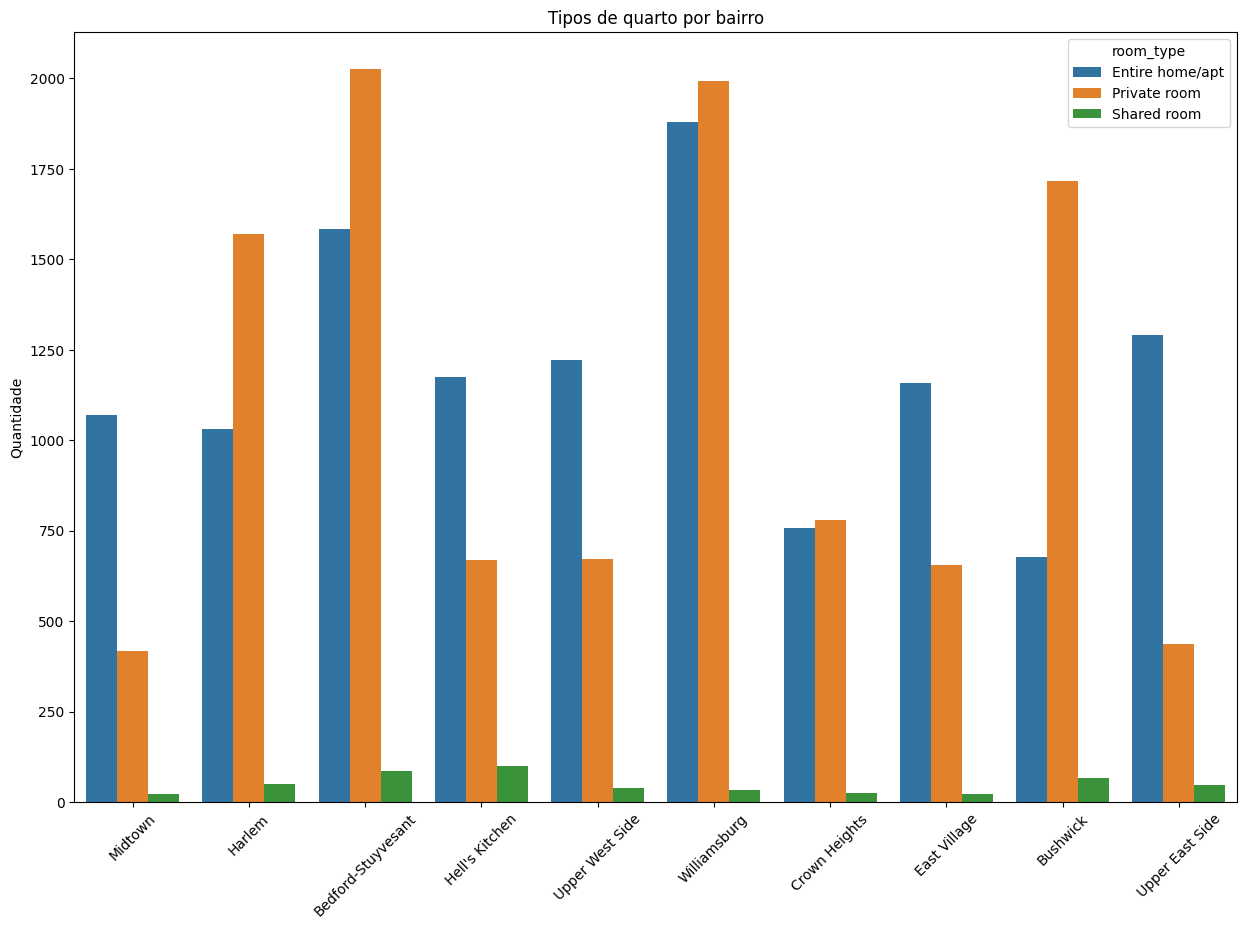

In [28]:
nyc_top10 = nyc[nyc["neighbourhood"].isin(top10_neighbours)]

sns.countplot(
    data=nyc_top10, 
    x="neighbourhood", 
    hue="room_type"
)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.title("Tipos de quarto por bairro")
plt.xlabel("")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.show()

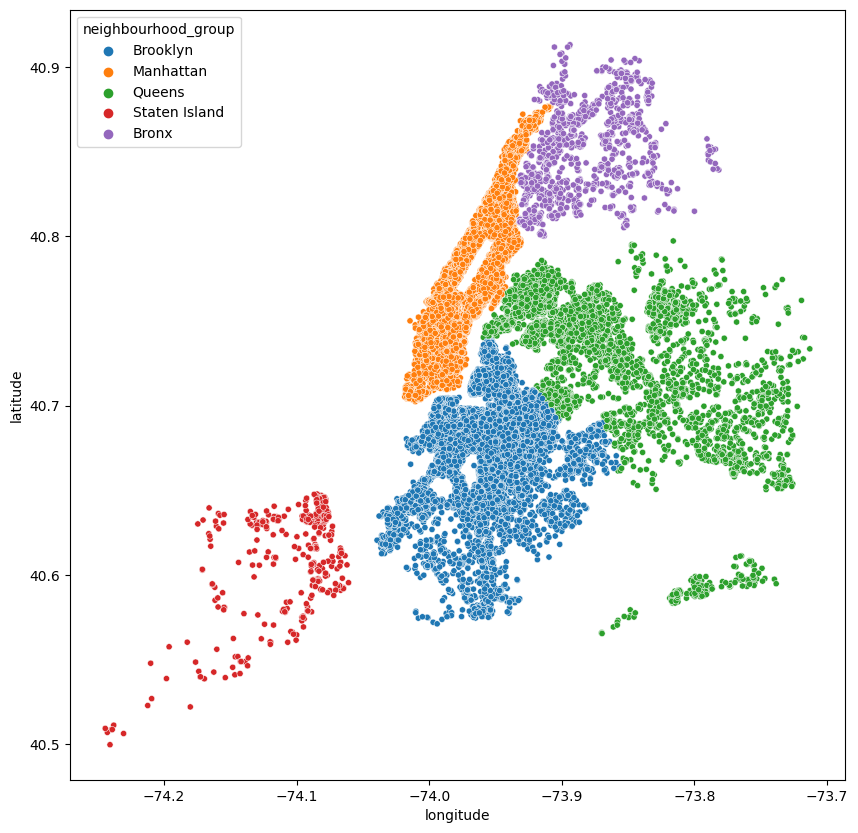

In [29]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=nyc,
    x='longitude', 
    y='latitude', 
    hue='neighbourhood_group',
    s=20
)

plt.show()

### Dados geográficos

In [ ]:
nyc_geo = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc_geo.head(5)

In [ ]:
nyc_geo.rename(columns={ "BoroName": "neighbourhood_group" }, inplace=True)

# Conta por distrito
neighbour_amount = nyc.groupby('neighbourhood_group').agg('count').reset_index()

# Dado para visualização no mapa
nyc_view = nyc_geo.merge(neighbour_amount, on="neighbourhood_group")

In [ ]:
# Plotar mapa com os distritos e a quantidade de airbnbs
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nyc_view.plot(column='id', alpha=.5, ax=ax, legend=True)
nyc_view.apply(lambda x: ax.annotate(text=x.neighbourhood_group, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.title("Quantidade de Airbnb por distrito")
plt.axis('off')
plt.show()

### Correlação entre as variáveis

C:\Users\James\AppData\Local\Temp\ipykernel_20044\323610818.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(nyc.corr(), annot=True, linewidths=5, ax=ax)


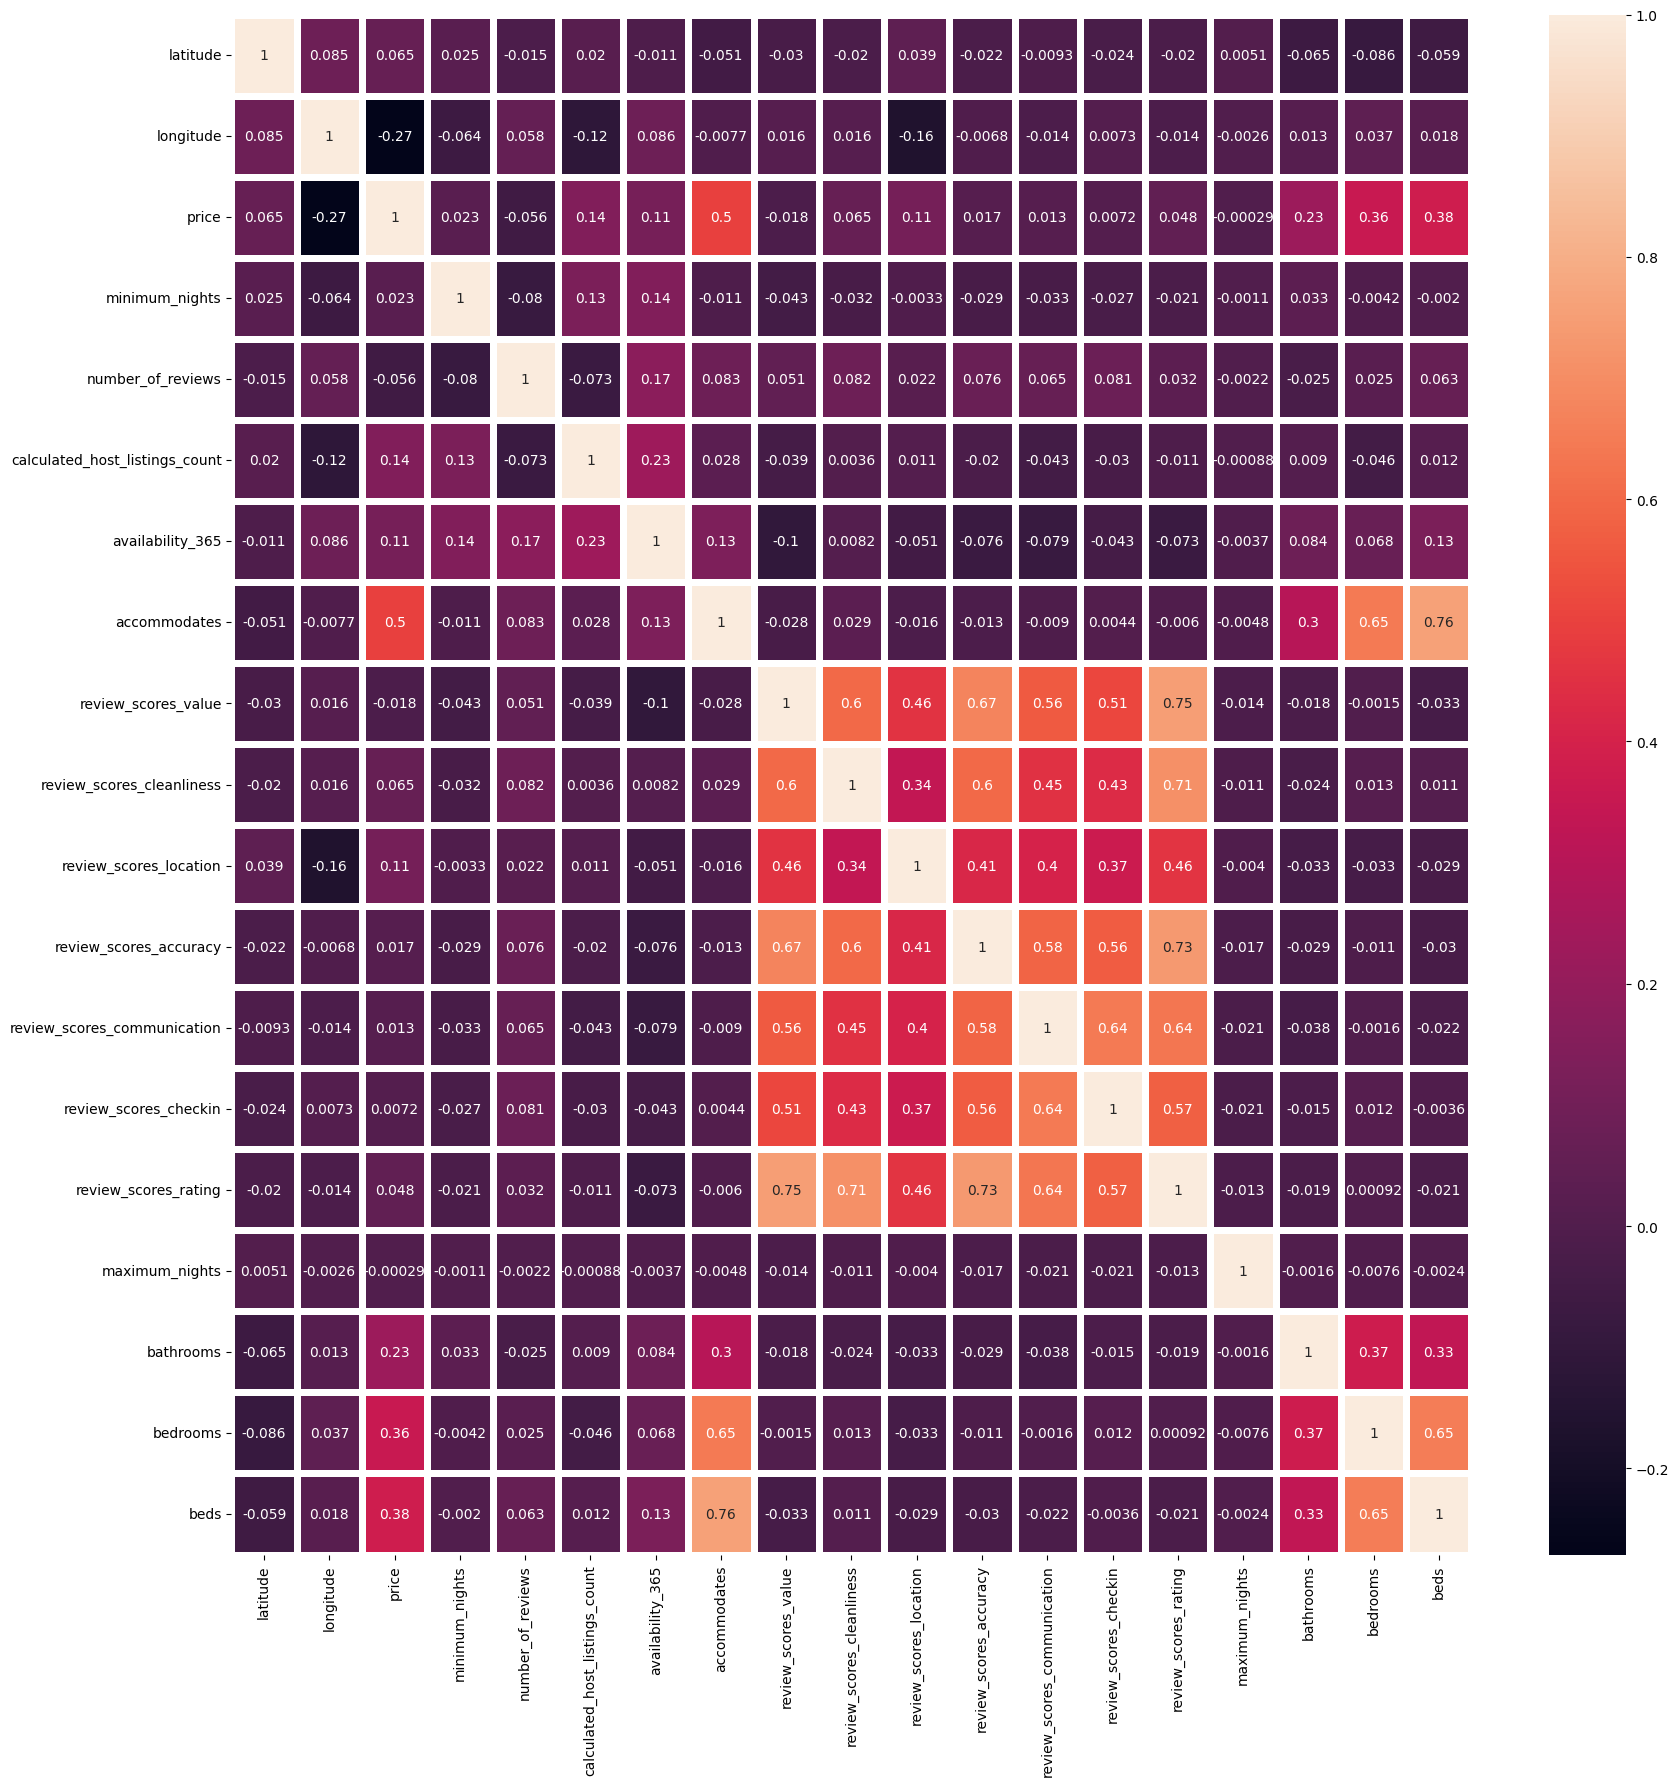

In [30]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(nyc.corr(), annot=True, linewidths=5, ax=ax)

plt.show()

# Preparando os dados para os modelos

### Separando X e y

In [32]:
# Variável dependente
nyc_labels = nyc["price"].copy()

# Variáveis independentes
nyc_x = nyc.drop(columns=["price", "neighbourhood"], axis="columns").copy()

In [33]:
nyc_x.head(3).transpose()

id,2539,2595,3647
neighbourhood_group,Brooklyn,Manhattan,Manhattan
latitude,40.64749,40.75362,40.80902
longitude,-73.97237,-73.98377,-73.9419
room_type,Private room,Entire home/apt,Private room
minimum_nights,1,1,3
number_of_reviews,9,45,0
calculated_host_listings_count,6,2,1
availability_365,365,355,365
property_type,Apartment,Apartment,Apartment
accommodates,2.823851,2.0,2.0


### Pipelines para preparação dos dados

In [34]:
scaler = StandardScaler()
encoder_1hot = OneHotEncoder(categories="auto", sparse=False)

# Pipeline para variáveis numéricas
num_pipeline = Pipeline([
    ("std_scaler", scaler)
])

# Pipeline para variáveis categóricas
cat_pipeline = Pipeline([
    ("cat_encoder", encoder_1hot)
])

In [35]:
# Separa colunas categóricas e numéricas
cat_attrs = ["neighbourhood_group", "room_type", "host_response_time", "property_type", "host_is_superhost"]
num_attrs = [col for col in list(nyc_x.columns) if col not in cat_attrs]

# Une pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("cat", cat_pipeline, cat_attrs)
])

# Aplica pipeline completo às variáveis independentes
nyc_prepared = full_pipeline.fit_transform(nyc_x)

### Divisão dos dados em treinamento e testes

In [36]:
# Divide os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    nyc_prepared,
    nyc_labels,
    test_size=0.3,
    random_state=RANDOM_SEED,
)

# Construindo modelos preditivos

### Regressão Linear mais simples do universo

In [37]:
cv = 5
n_jobs = -1

In [38]:
%%time

reg_linear = LinearRegression()

# GridSearch
grid_search_lr = GridSearchCV(
    estimator=reg_linear,
    param_grid={
        "fit_intercept": [True, False],
        "copy_X": [True, False]
    },
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=n_jobs
)

# Encontra os melhores parâmetros
grid_search_lr.fit(X_train, y_train)

best_params_lr = grid_search_lr.best_params_ 
print(f"Melhores parâmetros para regressão linear: {best_params_lr}")

Melhores parâmetros para regressão linear: {'copy_X': True, 'fit_intercept': False}
CPU times: total: 688 ms
Wall time: 6.46 s


In [43]:
# Sem ajustes
simple_LR = LinearRegression()
simple_model_LR = simple_LR.fit(X_train, y_train)
y_pred = simple_model_LR.predict(X_test)

print("============= SEM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}\n")

# Modelo ajustado
model_reg_linear = grid_search_lr.best_estimator_
y_pred = model_reg_linear.predict(X_test)

print("============= COM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")

============= SEM AJUSTES =============
R² = -2.2731707620608248e+18
MSE = 2.7164578533755423e+22

============= COM AJUSTES =============
R² = -482634335430332.1
MSE = 5.767520208643848e+18


### Lasso

In [39]:
%%time

lasso = Lasso(random_state=RANDOM_SEED)

# Grid search
alpha_list = np.geomspace(1e-3, 1, num=4).tolist()
tol_list = np.geomspace(1e-5, 1e-2, num=4).tolist()

grid_search_lasso = GridSearchCV(
    estimator=lasso,
    param_grid={
        "alpha": alpha_list,
        "selection": ["cyclic", "random"],
        "tol": tol_list
    },
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=n_jobs
)

# Encontra melhores parâmetros
grid_search_lasso.fit(X_train, y_train)
best_params_lasso = grid_search_lasso.best_params_

print(f"Melhores parâmetros para regressão linear: {best_params_lasso}")

Melhores parâmetros para regressão linear: {'alpha': 0.01, 'selection': 'cyclic', 'tol': 0.01}
CPU times: total: 3.64 s
Wall time: 1min 39s


In [44]:
# Sem ajustes
simple_Lasso = Lasso()
simple_model_lasso = simple_Lasso.fit(X_train, y_train)
y_pred = simple_model_lasso.predict(X_test)

print("============= SEM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}\n")

# Modelo ajustado
model_lasso = grid_search_lasso.best_estimator_
y_pred = model_lasso.predict(X_test)

print("============= COM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")

============= SEM AJUSTES =============
R² = 0.4685632316155889
MSE = 6350.71331703027

============= COM AJUSTES =============
R² = 0.49867931874200555
MSE = 5990.823586118327


### Ridge

In [46]:
%%time

ridge = Ridge(random_state=RANDOM_SEED)

# Grid search
solvers = ["auto", "svd", "lsqr", "sparse_cg"]

grid_search_ridge = GridSearchCV(
    estimator=ridge,
    param_grid={
        "alpha": alpha_list,
        "tol": tol_list,
        "solver": solvers
    },
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=n_jobs
)

grid_search_ridge.fit(X_train, y_train)
best_params_ridge = grid_search_ridge.best_params_

print(f"Melhores parâmetros para Ridge: {best_params_ridge}")

Melhores parâmetros para Ridge: {'alpha': 0.01, 'solver': 'sparse_cg', 'tol': 0.01}
CPU times: total: 4.02 s
Wall time: 42.6 s


In [47]:
# Sem ajustes
simple_ridge = Ridge()
simple_model_ridge = simple_ridge.fit(X_train, y_train)
y_pred = simple_model_ridge.predict(X_test)

print("============= SEM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}\n")

# Modelo ajustado
model_ridge = grid_search_ridge.best_estimator_
y_pred = model_ridge.predict(X_test)

print("============= COM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")

============= SEM AJUSTES =============
R² = 0.49863942825108654
MSE = 5991.300280782628

============= COM AJUSTES =============
R² = 0.4966127608889088
MSE = 6015.5191233089


### ElasticNet

In [48]:
%%time

elastic_net = ElasticNet(random_state=RANDOM_SEED)

# Grid search

grid_search_enet = GridSearchCV(
    estimator=elastic_net,
    param_grid={
        "alpha": alpha_list,
        "l1_ratio": [0, 0.25, 0.5, 0.75, 1],
    },
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=n_jobs
)

grid_search_enet.fit(X_train, y_train)
best_params_enet = grid_search_enet.best_params_

print(f"Melhores parâmetros para Elastic Net: {best_params_enet}")

Melhores parâmetros para Elastic Net: {'alpha': 0.01, 'l1_ratio': 1}
CPU times: total: 3.47 s
Wall time: 1min 28s


In [49]:
# Sem ajustes
simple_enet = ElasticNet()
simple_model_enet = simple_enet.fit(X_train, y_train)
y_pred = simple_model_enet.predict(X_test)

print("============= SEM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}\n")

# Modelo ajustado
model_enet = grid_search_enet.best_estimator_
y_pred = model_enet.predict(X_test)

print("============= COM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")

============= SEM AJUSTES =============
R² = 0.4108200900464981
MSE = 7040.748632510609

============= COM AJUSTES =============
R² = 0.49865698902845845
MSE = 5991.090428041252


### Decision Tree Regression

In [50]:
%%time

decision_tree = DecisionTreeRegressor(random_state=RANDOM_SEED)

grid_search_tree = GridSearchCV(
    estimator=decision_tree,
    param_grid={
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
        'min_samples_leaf': [1, 2, 3, 4, 5],
        'min_samples_split': [2, 3, 4, 5],
    },
    cv=cv,
    n_jobs=n_jobs,
    verbose=1,
    scoring="neg_mean_squared_error"
)

grid_search_tree.fit(X_train, y_train)
best_params_tree = grid_search_tree.best_params_

print(f"Melhores parâmetros para Árvore de Decisão: {best_params_tree}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Melhores parâmetros para Árvore de Decisão: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}
CPU times: total: 6.44 s
Wall time: 46.6 s


In [51]:
# Sem ajustes
simple_tree = DecisionTreeRegressor(random_state=RANDOM_SEED)
simple_model_tree = simple_tree.fit(X_train, y_train)
y_pred = simple_model_tree.predict(X_test)

print("============= SEM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}\n")

# Modelo ajustado
model_tree = grid_search_tree.best_estimator_
y_pred = model_tree.predict(X_test)

print("============= COM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")

============= SEM AJUSTES =============
R² = 0.28028285122811236
MSE = 8600.67942813939

============= COM AJUSTES =============
R² = 0.5554442127160547
MSE = 5312.47841027223


In [52]:
# Avaliando features mais importantes
grid_search_tree.best_estimator_.feature_importances_

array([4.70815027e-02, 9.09808658e-02, 6.84820224e-03, 1.19672541e-02,
       1.62824999e-02, 1.63215781e-02, 3.55987263e-02, 0.00000000e+00,
       1.41827021e-03, 3.13177521e-04, 0.00000000e+00, 0.00000000e+00,
       5.65302744e-04, 7.88975092e-04, 2.26138147e-03, 1.51457665e-01,
       8.49624743e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.81687431e-02, 0.00000000e+00, 0.00000000e+00, 4.14900257e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.13554031e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.00215679e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.29249436e-04, 0.00000000e+00, 0.00000000e+00, 1.78195382e-04,
      

### Random Forest Regressor

In [53]:
%%time

forest = RandomForestRegressor(random_state=RANDOM_SEED)

# train across 5 folds, that's a total of (6+4)*5=50 rounds of training.
grid_search_forest = GridSearchCV(
    estimator=forest,
    param_grid=[
        {
            'n_estimators': [10, 30],
            'max_features': [4, 6, 8],
        },
        {
            'bootstrap': [False],
            'n_estimators': [3, 10],
            'max_features': [3, 4],
        }
    ],
    cv=cv,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=n_jobs,
)

grid_search_forest.fit(X_train, y_train)
best_params_forest = grid_search_forest.best_params_

print(f"Melhores parâmetros para Random Forest Classifier: {best_params_forest}")

Melhores parâmetros para Random Forest Classifier: {'max_features': 8, 'n_estimators': 30}
CPU times: total: 2.34 s
Wall time: 15.9 s


In [54]:
# Sem ajustes
simple_forest = RandomForestRegressor(random_state=RANDOM_SEED)
simple_model_forest = simple_forest.fit(X_train, y_train)
y_pred = simple_model_forest.predict(X_test)

print("============= SEM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}\n")

# Modelo ajustado
model_forest = grid_search_forest.best_estimator_
y_pred = model_forest.predict(X_test)

print("============= COM AJUSTES =============")
print(f"R² = {r2_score(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")

============= SEM AJUSTES =============
R² = 0.6368656916475346
MSE = 4339.485005780465

============= COM AJUSTES =============
R² = 0.6254685846091326
MSE = 4475.6813771087745


In [55]:
grid_search_forest.best_estimator_.feature_importances_

array([9.14027577e-02, 1.22525403e-01, 3.67242410e-02, 3.55356759e-02,
       2.98893728e-02, 5.60371580e-02, 9.02254948e-02, 8.85775117e-03,
       1.01988669e-02, 1.07538626e-02, 7.22927622e-03, 7.38175937e-03,
       6.06547403e-03, 1.82474330e-02, 2.77192053e-02, 5.25415305e-02,
       5.59173229e-02, 5.69595236e-02, 9.24258392e-04, 8.23710835e-03,
       3.01425860e-02, 4.51338528e-03, 8.13866643e-04, 7.25670825e-02,
       9.02240644e-02, 6.77738012e-03, 1.61465851e-03, 4.10994579e-03,
       4.17547972e-03, 5.43720382e-03, 6.94167390e-05, 9.93313501e-03,
       1.59832072e-07, 1.32593406e-04, 1.78198746e-05, 2.50976381e-03,
       3.72815855e-05, 0.00000000e+00, 1.60427892e-05, 3.41139855e-05,
       1.07230341e-08, 0.00000000e+00, 2.44178222e-05, 3.33062903e-03,
       5.88638310e-07, 8.15584473e-07, 1.54790293e-07, 4.47142942e-07,
       4.10267686e-04, 6.09317631e-05, 1.05557980e-04, 1.36874096e-03,
       2.87060848e-03, 2.75924229e-04, 0.00000000e+00, 4.30649204e-03,
      

### K-Neighbors Regressor

In [56]:
# vamos guardar os resultados em algumas variáveis
resultados_predicao = {}
erros_predicao = {}

In [58]:
knn = KNeighborsRegressor(5, metric="euclidean")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE: {}".format(mse))
print("MAE: {}".format(mae))
print("RMSE: {}".format(rmse))
print("---")
print("R2: {}".format(r2))

MSE: 5433.798765550898
MAE: 44.01501134098563
RMSE: 73.7143050265747
---
R2: 0.54529195196518


In [59]:
resultados_predicao ['KNN-sem-ajuste'] = y_pred
erros_predicao ['KNN-sem-ajuste'] = [mse, r2]

resultados_df = pd.DataFrame(
    {
        'valor-real': np.array(y_test).flatten(), 
        'KNN-sem-ajuste': y_pred.flatten()
    }
)

resultados_df.set_index('valor-real', inplace=True)

erros_df = pd.DataFrame(
        {
            'KNN-sem-ajuste': [mse, r2]
        }     
)

erros_df.reset_index(inplace=True, drop=True)
erros_df.index = ['MSE', 'R2']

resultados_df.head(), erros_df.T.head()

(            KNN-sem-ajuste
 valor-real                
 91                   172.2
 325                  104.4
 225                  225.0
 145                  191.8
 333                  189.8,
                         MSE        R2
 KNN-sem-ajuste  5433.798766  0.545292)

#### Ajustes de Hiperparâmetros para KNN

Para o KNN, podemos ajustar o Número de Vizinhos e a função de distância.

Além disso, podemos utilizar validação cruzada para mensurar o desempenho das alterações

In [61]:
from sklearn.model_selection import GridSearchCV
param_grid = {'p': [1, 2],  
              'n_neighbors' : [ 5, 10, 15]
              } 

grid_knn = GridSearchCV(KNeighborsRegressor(n_jobs=-1), param_grid, refit = True, verbose = 10, n_jobs=-1, cv=5,scoring="neg_mean_squared_error") 

grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15], 'p': [1, 2]},
             scoring='neg_mean_squared_error', verbose=10)

In [62]:
print(f"Best parameters are {grid_knn.best_params_}") 
print("Best score is {}".format(grid_knn.best_score_ * -1))
print("Best model is {}".format(grid_knn.best_estimator_))

Best parameters are {'n_neighbors': 15, 'p': 1}
Best score is 4814.243002098917
Best model is KNeighborsRegressor(n_jobs=-1, n_neighbors=15, p=1)


In [63]:
knr_best = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=15, p=1,
                    weights='uniform')
knr_best.fit(X_train, y_train)
y_pred_best = knr_best.predict(X_test)

mse_knn_best = mean_squared_error(y_pred_best, y_test)
mae_knn_best = mean_absolute_error(y_pred, y_test)
rmse_knn_best = np.sqrt(mse)
r2_knn_best = r2_score(y_test, y_pred_best)

print("MSE -- ajustado: {}".format(mse_knn_best))
print("MAE -- ajustado: {}".format(mae_knn_best))
print("RMSE -- ajustado: {}".format(rmse_knn_best))
print("R2 -- ajustado: {}".format(r2_knn_best))

MSE -- ajustado: 4872.383775288105
MAE -- ajustado: 44.01501134098563
RMSE -- ajustado: 73.7143050265747
R2 -- ajustado: 0.5922719608639821


In [64]:
resultados_predicao ['KNN-ajustado'] = y_pred_best
resultados_df['KNN-ajustado'] = y_pred_best.flatten()
erros_predicao ['KNN-ajustado'] = [mse_knn_best, r2_knn_best]

In [65]:
resultados_predicao, erros_predicao, resultados_df

({'KNN-sem-ajuste': array([172.2, 104.4, 225. , ...,  89.8,  79.8, 141.4]),
  'KNN-ajustado': array([184.13333333, 112.73333333, 263.4       , ...,  95.4       ,
          83.86666667, 180.8       ])},
 {'KNN-sem-ajuste': [5433.798765550898, 0.54529195196518],
  'KNN-ajustado': [4872.383775288105, 0.5922719608639821]},
             KNN-sem-ajuste  KNN-ajustado
 valor-real                              
 91                   172.2    184.133333
 325                  104.4    112.733333
 225                  225.0    263.400000
 145                  191.8    184.533333
 333                  189.8    186.133333
 ...                    ...           ...
 60                    67.0     69.133333
 111                  233.4    189.800000
 62                    89.8     95.400000
 200                   79.8     83.866667
 245                  141.4    180.800000
 
 [14549 rows x 2 columns])

### Support Vector Machine

In [67]:
clf_svr = LinearSVR()
clf_svr.fit(X_train, y_train)

preds_svr = clf_svr.predict(X_test)

mse_svr = mean_squared_error(preds_svr, y_test)
mae_svr = mean_absolute_error(preds_svr, y_test)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, preds_svr)

print("MSE: {}".format(mse_svr))
print("MAE: {}".format(mae_svr))
print("RMSE: {}".format(rmse_svr))
print("---")
print("R2: {}".format(r2_svr))

MSE: 6753.400034640414
MAE: 45.72244641432983
RMSE: 82.17907297262737
---
R2: 0.43486583146619395


In [68]:
resultados_predicao['SVR-sem-ajuste'] = preds_svr
resultados_df['SVR-sem-ajuste'] = preds_svr.flatten()
erros_predicao['SVR-sem-ajuste'] = [mse_svr, r2_svr]

#### Ajustes de hiperparâmetro para SVR

Para SVR, podemos ajustar os parâmetros loss, C e dual e tol.

Utilizaremos a mesma técnica para medir o desempenho com validação cruzada.

In [69]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 
              'dual': [True, False],
              'tol': [0.0001, 0.00001]} 

grid = GridSearchCV(LinearSVR(), param_grid, refit = True, verbose = 10, n_jobs=-1, cv=5,scoring="neg_mean_squared_error") 

grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\James\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\James\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\James\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py", line 489, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\James\AppData\Local\Programs\Python\Python310\lib

GridSearchCV(cv=5, estimator=LinearSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'dual': [True, False],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'tol': [0.0001, 1e-05]},
             scoring='neg_mean_squared_error', verbose=10)

In [70]:
print(f"Best parameters are {grid.best_params_}") 
print("Best score is {}".format(grid.best_score_ * -1))
print("Best model is {}".format(grid.best_estimator_))
print("scores {}".format(grid.cv_results_['mean_test_score']))

Best parameters are {'C': 1, 'dual': True, 'loss': 'epsilon_insensitive', 'tol': 1e-05}
Best score is 6419.412972651358
Best model is LinearSVR(C=1, tol=1e-05)
scores [  -6634.23497097   -6634.55491846   -6841.30036483   -6841.4837074
              nan              nan   -6839.66577824   -6842.28098757
   -6421.98496798   -6419.41297265  -10078.96790613  -10096.74888742
              nan              nan  -10860.59513523  -10058.42281835
   -6659.4307516    -6663.04076618  -12694.48668524  -13755.14674398
              nan              nan  -11865.45053358  -10558.15574203
   -6633.82046132   -6630.04326205 -194471.14960204 -183780.26286129
              nan              nan  -10409.65992044  -11140.18726345
   -7032.68384079   -7037.29310066 -372990.42138369 -373100.5443531
              nan              nan  -11911.93106811  -10712.44757467]


In [71]:
svr_best = LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

svr_best.fit(X_train, y_train)

preds_svr_best = svr_best.predict(X_test)

mse_svr_best = mean_squared_error(preds_svr_best, y_test)
mae_svr_best = mean_absolute_error(preds_svr_best, y_test)
rmse_svr_best = np.sqrt(mse_svr_best)
r2_svr_best = r2_score(y_test, preds_svr_best)

print("MSE -- ajustado: {}".format(mse_svr_best))
print("MAE -- ajustado: {}".format(mae_svr_best))
print("RMSE -- ajustado: {}".format(rmse_svr_best))
print("R2 -- ajustado: {}".format(r2_svr_best))

MSE -- ajustado: 6763.69117101105
MAE -- ajustado: 45.720675505573354
RMSE -- ajustado: 82.24166323105977
R2 -- ajustado: 0.43400465446405334


In [72]:
resultados_predicao['SVR-ajustado'] = preds_svr_best
resultados_df['SVR-ajustado'] = preds_svr_best.flatten()
erros_predicao['SVR-ajustado'] = [mse_svr_best, r2_svr_best]